In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import statsmodels.formula.api as sm

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv(r"geocod_parcial_corrigido.csv")
df.head()

,Protocolo,Endereço,Número,Bairro,Zona,Setor,DataInclusao,Cadastro,Assunto,Descrição,Origem,Cidade,Estado,Pais,DataInclusao_BR,endereco_completo,latitude,longitude,endereco_formatado
0,649554,Alameda Amor Perfeito,36,Zona 04 - centro,60,IAM - Fiscalização,2022-11-14 22:20:00,60130700,Poluição sonora por estabelecimento comercial,Som ao vivo fora do estabelecimento provocando...,Identificados,Maringá,Paraná,Brasil,22:20:00 14-11-2022,"Alameda Amor Perfeito, 36, Maringá - PR, Brasil",-23.360488,-52.014885,Alameda Amor Perfeito - Conj. Hab. Joao de Bar...
1,601042,Alameda Das Alfazemas,1968,Zona 3,60,IAM - Fiscalização,2022-05-21 23:54:00,60067500,Poluição sonora por estabelecimento comercial,Muito barulho som alto de dois bares thel bar ...,Identificados,Maringá,Paraná,Brasil,23:54:00 21-05-2022,"Alameda Das Alfazemas, 1968, Maringá - PR, Brasil",-23.357035,-52.009594,Alameda das Alfazemas - Conj. Hab. Joao de Bar...
2,660699,Alameda Doutor João Paulino,673,JARDIM ALVORADA I PARTE,24,IAM - Fiscalização,2022-12-23 23:49:00,24130900.0,Poluição sonora por estabelecimento comercial,Vizinho vários dias com som alto além da hora....,Sigilosos,Maringá,Paraná,Brasil,23:49:00 23-12-2022,"Alameda Doutor João Paulino, 673, Maringá - PR...",-23.400397,-51.921264,"Alameda Dr. João Paulino, 673 - Jardim Alvorad..."
3,784845,Avenida Advogado Horácio Raccanello Filho,183,Vila nova,18,IAM - Fiscalização,2023-12-23 08:56:00,18039700.0,Poluição sonora por estabelecimento comercial,Esse estabelecimento permanece com o som alto ...,Sigilosos,Maringá,Paraná,Brasil,08:56:00 23-12-2023,"Avenida Advogado Horácio Raccanello Filho, 183...",-23.420447,-51.924922,"Av. Advogado Horácio Raccanello Filho, 183 - Z..."
4,648166,Avenida Advogado Horácio Raccanello Filho,3605,ZONA ARMAZÉM,9,IAM - Fiscalização,2022-11-09 08:45:00,9014300.0,Poluição sonora por estabelecimento comercial,na madrugada de terça para quarta (dia 08 para...,Sigilosos,Maringá,Paraná,Brasil,08:45:00 09-11-2022,"Avenida Advogado Horácio Raccanello Filho, 360...",-23.423895,-51.914974,"Av. Advogado Horácio Raccanello Filho, 3605 - ..."


In [3]:
def plot_most_frequent(df, column, pct_cutoff=None, top_n=20):
    # Validações de entrada
    if not isinstance(df, pd.DataFrame):
        raise ValueError("df deve ser um pandas DataFrame")
    if column not in df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no DataFrame")
    if top_n is not None and (not isinstance(top_n, int) or top_n <= 0):
        raise ValueError("top_n deve ser um inteiro positivo ou None")
    if pct_cutoff is not None and (not isinstance(pct_cutoff, (int, float)) or not (0 <= pct_cutoff <= 100)):
        raise ValueError("pct_cutoff deve ser um número entre 0 e 100 ou None")

    # Filtra valores inválidos
    dados_validos = df[column].dropna()
    dados_validos = dados_validos[~dados_validos.isin([0, 'None', None])]

    freq = dados_validos.value_counts()
    total = freq.sum()

    if total == 0:
        print(f"Nenhuma ocorrência válida encontrada para a coluna '{column}'.")
        return freq, pd.Series(dtype=float)

    # Se pct_cutoff não informado, usa top_n (padrão 20)
    if pct_cutoff is None:
        freq_subset = freq.sort_values(ascending=False).head(top_n)
        cum_pct_subset = freq_subset.cumsum() / total * 100
        top_pct = freq_subset.sum() / total * 100
        title = f"Top {top_n} de {column} (representam {top_pct:.2f}% do total)"
    else:
        cum_pct = freq.cumsum() / total * 100
        mask = cum_pct <= pct_cutoff
        if mask.sum() == 0:
            # garante pelo menos um item
            mask.iloc[0] = True
        freq_subset = freq[mask]
        cum_pct_subset = cum_pct[mask]
        title = f"Frequência de {column} (Acumulado até {pct_cutoff}% - {freq_subset.size} dados únicos)"

    # Para 'endereco_formatado' omitir tudo após o primeiro '-' ao montar os rótulos do eixo x
    if column == 'endereco_formatado':
        x_labels = []
        for val in freq_subset.index:
            s = str(val).strip()
            # remove parte após o primeiro traço '-' (se existir)
            label = s.split('-', 1)[0].strip() if '-' in s else s
            # remover vírgulas/espacos finais e garantir fallback
            label = label.rstrip(' ,')
            if not label:
                label = s[:40] + '...' if len(s) > 40 else s
            # truncar rótulos muito longos
            if len(label) > 40:
                label = label[:40] + '...'
            x_labels.append(label)
    else:
        x_labels = freq_subset.index.astype(str).tolist()

    # Plot usando índices numéricos para x (melhor controle sobre rótulos longos)
    x = range(len(freq_subset))
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.bar(x, freq_subset.values, color='skyblue')
    ax1.set_xlabel('Mais frequentes')
    ax1.set_ylabel('Frequência')
    ax1.set_title(title)
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels, rotation=45, ha='right')

    ax2 = ax1.twinx()
    ax2.plot(x, cum_pct_subset.values, color='red', marker='o', label='Acumulado (%)')
    ax2.set_ylabel('Acumulado (%)')
    ax2.set_ylim(0, 110)
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    if pct_cutoff is None:
        print(f"Top {top_n} representam {top_pct:.2f}% do total de ocorrências em '{column}'")

    return freq_subset, cum_pct_subset


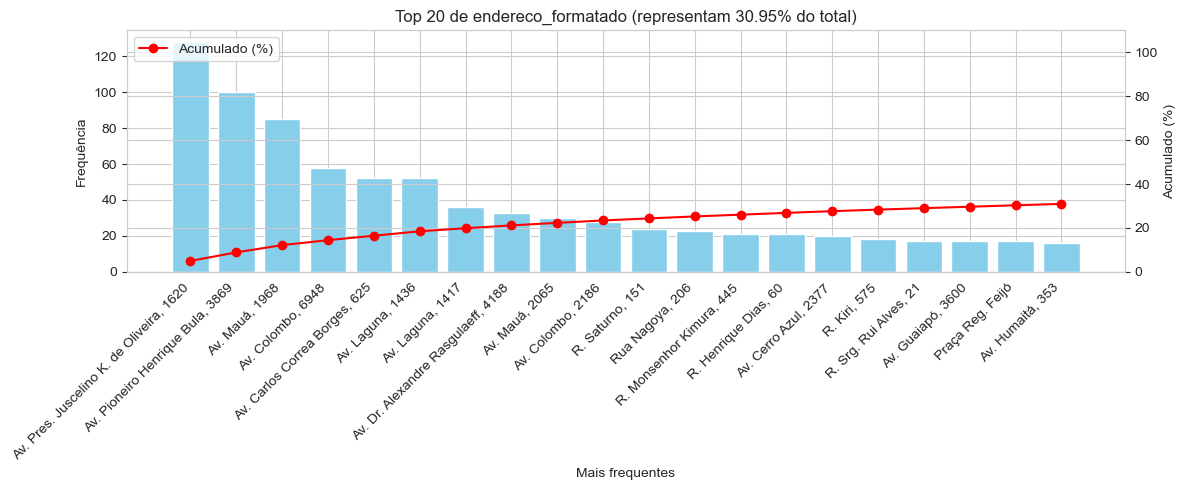

Top 20 representam 30.95% do total de ocorrências em 'endereco_formatado'


(endereco_formatado
 Av. Pres. Juscelino K. de Oliveira, 1620 - Zona 02, Maringá - PR, 87010-440, Brasil                      128
 Av. Pioneiro Henrique Bula, 3869 - Jardim Oasis, Maringá - PR, 87045-053, Brasil                         100
 Av. Mauá, 1968 - Zona 03, Maringá - PR, 87050-020, Brasil                                                 85
 Av. Colombo, 6948 - Zona 7, Maringá - PR, 87020-000, Brasil                                               58
 Av. Carlos Correa Borges, 625 - Conj. Hab. Inocente Vila Nova Júnior, Maringá - PR, 87060-215, Brasil     52
 Av. Laguna, 1436 - Zona 01, Maringá - PR, 87050-260, Brasil                                               52
 Av. Laguna, 1417 - Zona 03, Maringá - PR, 87050-260, Brasil                                               36
 Av. Dr. Alexandre Rasgulaeff, 4188 - Parque Res. Cidade Nova, Maringá - PR, 87023-060, Brasil             33
 Av. Mauá, 2065 - Zona 03, Maringá - PR, 87050-020, Brasil                                          

In [4]:
plot_most_frequent(df,'endereco_formatado')


In [5]:
df.columns

Index(['Protocolo', 'Endereço', 'Número', 'Bairro', 'Zona', 'Setor',
       'DataInclusao', 'Cadastro', 'Assunto', 'Descrição', 'Origem', 'Cidade',
       'Estado', 'Pais', 'DataInclusao_BR', 'endereco_completo', 'latitude',
       'longitude', 'endereco_formatado'],
      dtype='object')

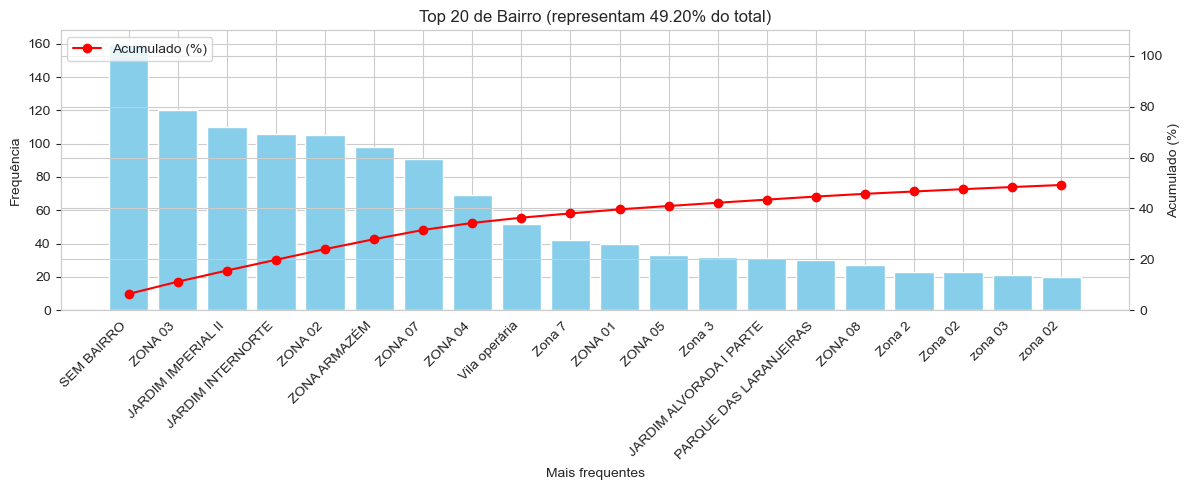

Top 20 representam 49.20% do total de ocorrências em 'Bairro'


(Bairro
 SEM BAIRRO                 160
 ZONA 03                    120
 JARDIM IMPERIAL II         110
 JARDIM INTERNORTE          106
 ZONA 02                    105
 ZONA ARMAZÉM                98
 ZONA 07                     91
 ZONA 04                     69
 Vila operária               52
 Zona 7                      42
 ZONA 01                     40
 ZONA 05                     33
 Zona 3                      32
 JARDIM ALVORADA I PARTE     31
 PARQUE DAS LARANJEIRAS      30
 ZONA 08                     27
 Zona 2                      23
 Zona 02                     23
 zona 03                     21
 zona 02                     20
 Name: count, dtype: int64,
 Bairro
 SEM BAIRRO                  6.384677
 ZONA 03                    11.173184
 JARDIM IMPERIAL II         15.562650
 JARDIM INTERNORTE          19.792498
 ZONA 02                    23.982442
 ZONA ARMAZÉM               27.893057
 ZONA 07                    31.524342
 ZONA 04                    34.277733
 Vila operár

In [6]:
plot_most_frequent(df,'Bairro')

In [7]:
def extrair_componentes(endereco):
    partes = endereco.split(',')
    if len(partes) < 5:
        return pd.Series({
            'rua_formatado': None,
            'num_formatado': None,
            'bairro_formatado': None,
            'cidade_formatado': None,
            'uf_formatado': None,
            'cep_formatado': None,
            'pais_formatado': None
        })
    rua = partes[0].strip()
    
    # Processa a segunda parte: "número - bairro"
    if '-' in partes[1]:
        subpartes = partes[1].split('-')
        num = subpartes[0].strip()
        bairro = subpartes[1].strip() if len(subpartes) > 1 else None
    else:
        num = partes[1].strip()
        bairro = None
    
    # Processa a terceira parte: "cidade - UF"
    if '-' in partes[2]:
        subpartes = partes[2].split('-')
        cidade = subpartes[0].strip()
        uf = subpartes[1].strip() if len(subpartes) > 1 else None
    else:
        cidade = partes[2].strip()
        uf = None

    cep = partes[3].strip()
    pais = partes[4].strip()
    
    return pd.Series({
        'rua_formatado': rua,
        'num_formatado': num,
        'bairro_formatado': bairro,
        'cidade_formatado': cidade,
        'uf_formatado': uf,
        'cep_formatado': cep,
        'pais_formatado': pais
    })

# Aplicar a função ao dataframe usando a coluna 'endereco_formatado'
novas_colunas = df['endereco_formatado'].apply(extrair_componentes)
df2 = pd.concat([df, novas_colunas], axis=1)
df2.head()

,Protocolo,Endereço,Número,Bairro,Zona,Setor,DataInclusao,Cadastro,Assunto,Descrição,...,latitude,longitude,endereco_formatado,rua_formatado,num_formatado,bairro_formatado,cidade_formatado,uf_formatado,cep_formatado,pais_formatado
0,649554,Alameda Amor Perfeito,36,Zona 04 - centro,60,IAM - Fiscalização,2022-11-14 22:20:00,60130700,Poluição sonora por estabelecimento comercial,Som ao vivo fora do estabelecimento provocando...,...,-23.360488,-52.014885,Alameda Amor Perfeito - Conj. Hab. Joao de Bar...,None,None,None,None,None,None,None
1,601042,Alameda Das Alfazemas,1968,Zona 3,60,IAM - Fiscalização,2022-05-21 23:54:00,60067500,Poluição sonora por estabelecimento comercial,Muito barulho som alto de dois bares thel bar ...,...,-23.357035,-52.009594,Alameda das Alfazemas - Conj. Hab. Joao de Bar...,None,None,None,None,None,None,None
2,660699,Alameda Doutor João Paulino,673,JARDIM ALVORADA I PARTE,24,IAM - Fiscalização,2022-12-23 23:49:00,24130900.0,Poluição sonora por estabelecimento comercial,Vizinho vários dias com som alto além da hora....,...,-23.400397,-51.921264,"Alameda Dr. João Paulino, 673 - Jardim Alvorad...",Alameda Dr. João Paulino,673,Jardim Alvorada,Maringá,PR,87033-450,Brasil
3,784845,Avenida Advogado Horácio Raccanello Filho,183,Vila nova,18,IAM - Fiscalização,2023-12-23 08:56:00,18039700.0,Poluição sonora por estabelecimento comercial,Esse estabelecimento permanece com o som alto ...,...,-23.420447,-51.924922,"Av. Advogado Horácio Raccanello Filho, 183 - Z...",Av. Advogado Horácio Raccanello Filho,183,Zona 7,Maringá,PR,87030-040,Brasil
4,648166,Avenida Advogado Horácio Raccanello Filho,3605,ZONA ARMAZÉM,9,IAM - Fiscalização,2022-11-09 08:45:00,9014300.0,Poluição sonora por estabelecimento comercial,na madrugada de terça para quarta (dia 08 para...,...,-23.423895,-51.914974,"Av. Advogado Horácio Raccanello Filho, 3605 - ...",Av. Advogado Horácio Raccanello Filho,3605,Vila Ipiranga,Maringá,PR,87045-200,Brasil


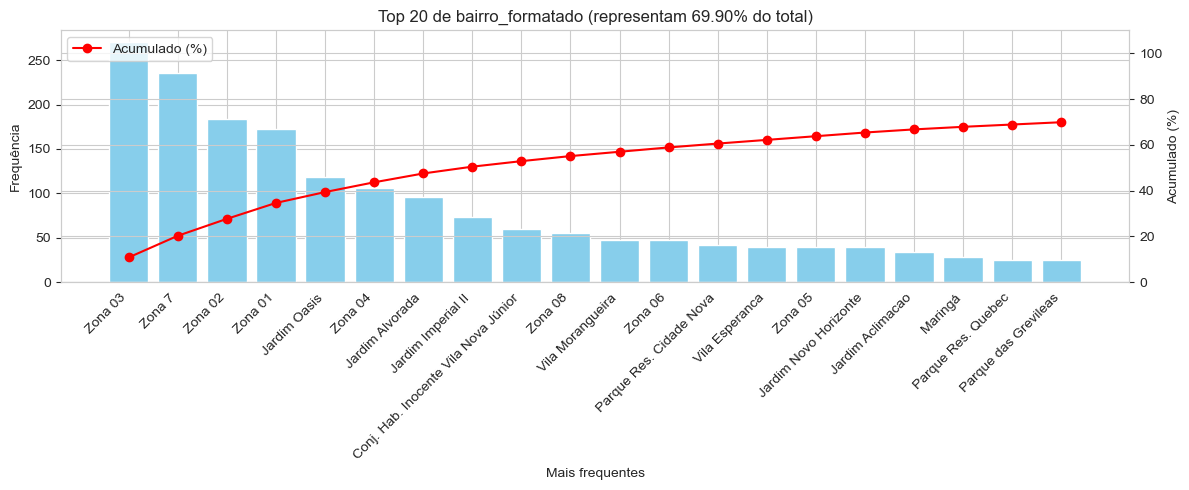

Top 20 representam 69.90% do total de ocorrências em 'bairro_formatado'


In [8]:
# usa df2 (parsing já feito) se disponível, caso contrário tenta usar df
source = df2 if 'df2' in globals() and 'bairro_formatado' in df2.columns else df

# excluir nulos, strings vazias e marcas como "SEM BAIRRO" (caso-insensitivo)
bad_values = {'', 'NONE', 'N/A', 'SEM BAIRRO'}
mask = source['bairro_formatado'].notna() & (~source['bairro_formatado'].astype(str).str.strip().str.upper().isin(bad_values))
filtered = source[mask].copy()

if filtered.empty:
    print("Nenhum registro com 'bairro_formatado' válido encontrado.")
else:
    plot_most_frequent(filtered, 'bairro_formatado')

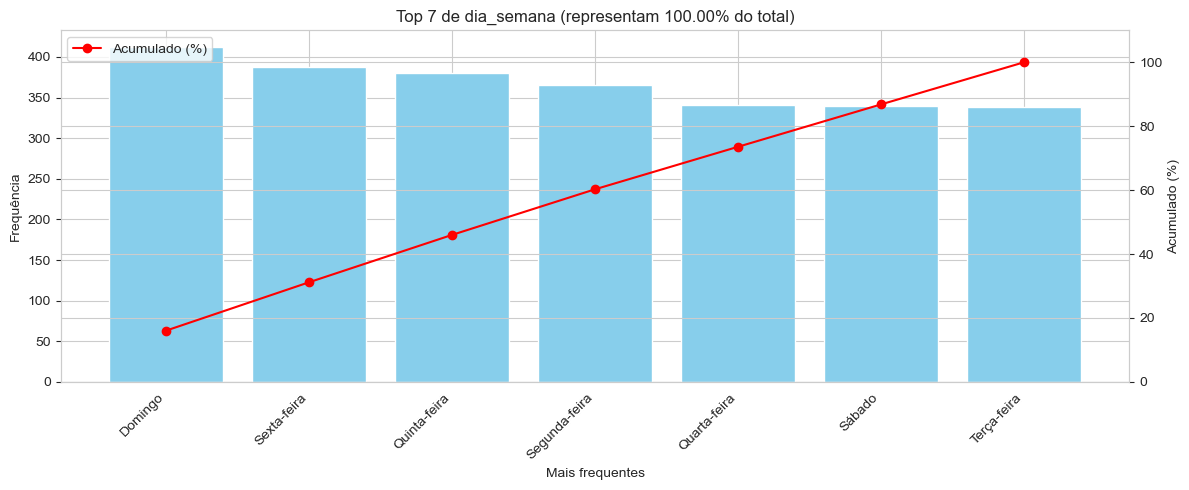

Top 7 representam 100.00% do total de ocorrências em 'dia_semana'


(dia_semana
 Domingo          412
 Sexta-feira      388
 Quinta-feira     380
 Segunda-feira    366
 Quarta-feira     341
 Sábado           340
 Terça-feira      338
 Name: count, dtype: int64,
 dia_semana
 Domingo           16.062378
 Sexta-feira       31.189084
 Quinta-feira      46.003899
 Segunda-feira     60.272904
 Quarta-feira      73.567251
 Sábado            86.822612
 Terça-feira      100.000000
 Name: count, dtype: float64)

In [9]:
def add_weekday_from_datetime_column(df, date_col='DataInclusao', out_col='dia_semana'):
    """
    Converte date_col para datetime (coerce) e adiciona:
      - {out_col}_dt: datetime
      - {out_col}_num: weekday (0=segunda ... 6=domingo) com NaN para valores inválidos
      - {out_col}: nome do dia da semana em português
    Modifica o DataFrame in-place e retorna o DataFrame.
    """
    if date_col not in df.columns:
        raise KeyError(f"Coluna '{date_col}' não encontrada no DataFrame")
    dt = pd.to_datetime(df[date_col], errors='coerce')
    df[f'{out_col}_dt'] = dt
    df[f'{out_col}_num'] = dt.dt.weekday  # Monday=0
    weekdays_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
    df[out_col] = df[f'{out_col}_num'].apply(lambda x: weekdays_pt[int(x)] if pd.notna(x) else None)
    return df

# escolhe df2 se disponível, caso contrário df
target = df2 if 'df2' in globals() else df
add_weekday_from_datetime_column(target, 'DataInclusao', 'dia_semana')

# visual check
target[['DataInclusao', 'dia_semana_dt', 'dia_semana_num', 'dia_semana']].head()

plot_most_frequent(target,'dia_semana', top_n=7)

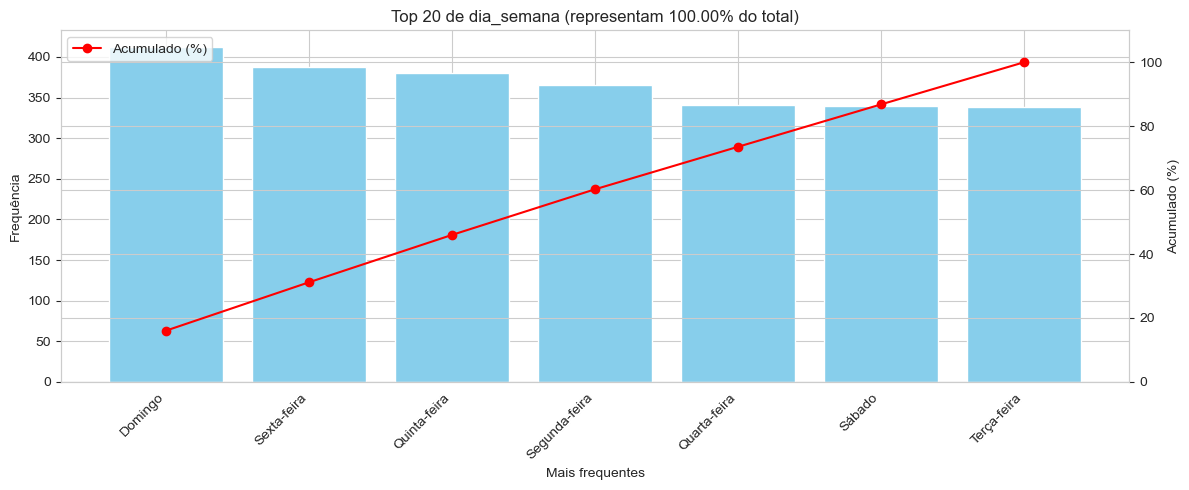

Top 20 representam 100.00% do total de ocorrências em 'dia_semana'


(dia_semana
 Domingo          412
 Sexta-feira      388
 Quinta-feira     380
 Segunda-feira    366
 Quarta-feira     341
 Sábado           340
 Terça-feira      338
 Name: count, dtype: int64,
 dia_semana
 Domingo           16.062378
 Sexta-feira       31.189084
 Quinta-feira      46.003899
 Segunda-feira     60.272904
 Quarta-feira      73.567251
 Sábado            86.822612
 Terça-feira      100.000000
 Name: count, dtype: float64)

In [10]:
plot_most_frequent(target,'dia_semana')

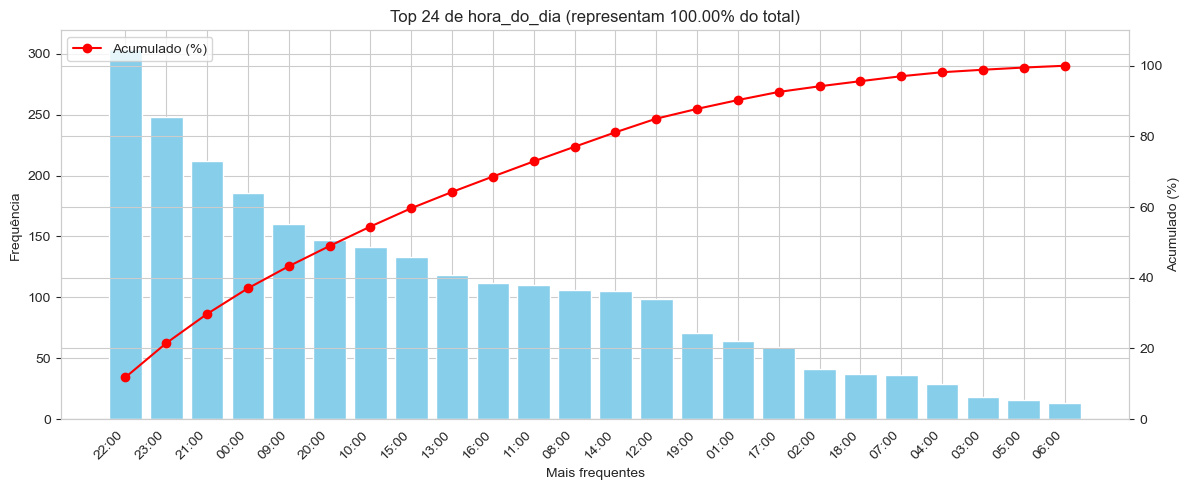

Top 24 representam 100.00% do total de ocorrências em 'hora_do_dia'


(hora_do_dia
 22:00    304
 23:00    248
 21:00    212
 00:00    186
 09:00    160
 20:00    147
 10:00    141
 15:00    133
 13:00    118
 16:00    112
 11:00    110
 08:00    106
 14:00    105
 12:00     99
 19:00     71
 01:00     64
 17:00     59
 02:00     41
 18:00     37
 07:00     36
 04:00     29
 03:00     18
 05:00     16
 06:00     13
 Name: count, dtype: int64,
 hora_do_dia
 22:00     11.851852
 23:00     21.520468
 21:00     29.785575
 00:00     37.037037
 09:00     43.274854
 20:00     49.005848
 10:00     54.502924
 15:00     59.688109
 13:00     64.288499
 16:00     68.654971
 11:00     72.943470
 08:00     77.076023
 14:00     81.169591
 12:00     85.029240
 19:00     87.797271
 01:00     90.292398
 17:00     92.592593
 02:00     94.191033
 18:00     95.633528
 07:00     97.037037
 04:00     98.167641
 03:00     98.869396
 05:00     99.493177
 06:00    100.000000
 Name: count, dtype: float64)

In [11]:
# gera coluna com hora do dia e plota (independente da data) usando plot_most_frequent
src = target if 'target' in globals() else df2 if 'df2' in globals() else df

# garantir coluna datetime
if 'dia_semana_dt' not in src.columns:
    tmp = src.copy()
    tmp['dia_semana_dt'] = pd.to_datetime(tmp['DataInclusao'], errors='coerce')
else:
    tmp = src.copy()

# extrai hora e formata como "HH:00"
tmp['hora_do_dia'] = tmp['dia_semana_dt'].dt.hour.apply(lambda h: f"{int(h):02d}:00" if pd.notna(h) else None)

# plota as horas do dia (top_n=24 para cobrir todas as horas)
plot_most_frequent(tmp, 'hora_do_dia', top_n=24)


Mais frequente: Maio — 322 ocorrências (12.55% do total)\n
Janeiro      111
Fevereiro    129
Março        133
Abril        112
Maio         322
Junho        195
Julho        248
Agosto       302
Setembro     256
Outubro      272
Novembro     262
Dezembro     223
Name: count, dtype: int64


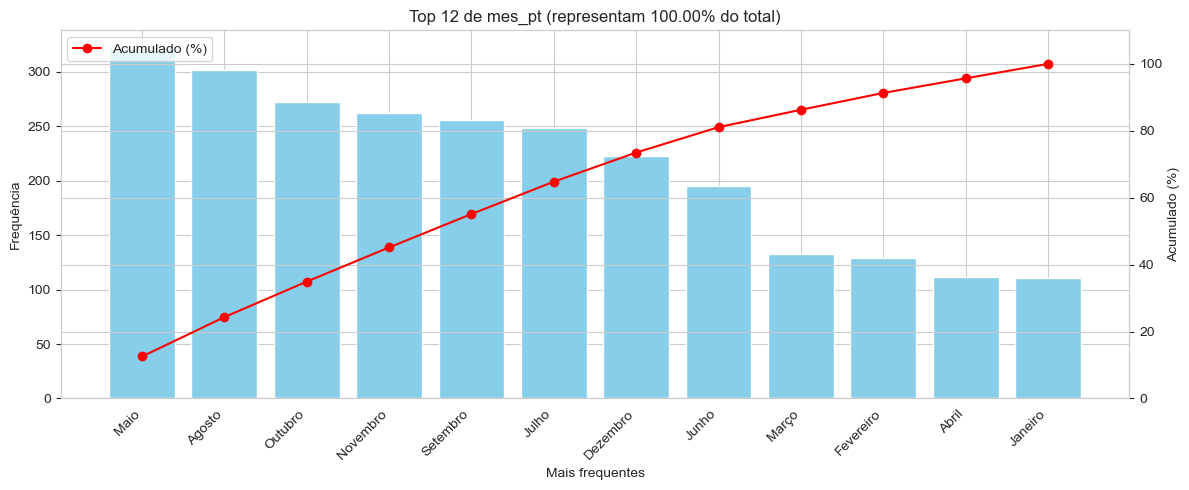

Top 12 representam 100.00% do total de ocorrências em 'mes_pt'


(mes_pt
 Maio         322
 Agosto       302
 Outubro      272
 Novembro     262
 Setembro     256
 Julho        248
 Dezembro     223
 Junho        195
 Março        133
 Fevereiro    129
 Abril        112
 Janeiro      111
 Name: count, dtype: int64,
 mes_pt
 Maio          12.553606
 Agosto        24.327485
 Outubro       34.931774
 Novembro      45.146199
 Setembro      55.126706
 Julho         64.795322
 Dezembro      73.489279
 Junho         81.091618
 Março         86.276803
 Fevereiro     91.306043
 Abril         95.672515
 Janeiro      100.000000
 Name: count, dtype: float64)

In [12]:
# escolhe fonte existente
src = target if 'target' in globals() else df2 if 'df2' in globals() else df

# determina coluna datetime disponível
if 'dia_semana_dt' in src.columns:
    dt = src['dia_semana_dt']
else:
    dt = pd.to_datetime(src['DataInclusao'], errors='coerce')

# nomes dos meses em português
meses_pt = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho',
            'Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']

# conta por mês (ignorando NaT), reorganiza para Jan..Dez
mes_nums = dt.dt.month.dropna().astype(int)
counts = mes_nums.value_counts().sort_index()
counts = counts.reindex(range(1,13), fill_value=0)
counts.index = meses_pt

# resultado e plot
total = counts.sum()
top_mes = counts.idxmax()
top_val = counts.max()
top_pct = top_val / total * 100 if total > 0 else 0

print(f"Mais frequente: {top_mes} — {top_val} ocorrências ({top_pct:.2f}% do total)\\n")
# cria coluna com nome do mês em pt e usa plot_most_frequent
src['mes_pt'] = dt.dt.month.apply(lambda m: meses_pt[int(m)-1] if pd.notna(m) else None)

print(counts)
plot_most_frequent(src.dropna(subset=['mes_pt']), 'mes_pt', top_n=12)


Note: you may need to restart the kernel to use updated packages.
contextily não disponível ou falhou ao importar. Basemap será ignorado.
Erro: dlopen(/opt/anaconda3/envs/artigo_ambiental/lib/python3.13/site-packages/rasterio/_base.cpython-313-darwin.so, 0x0002): Library not loaded: @rpath/libnetcdf.19.dylib
  Referenced from: <A2860E87-DCA6-3E1C-869C-97EF1B16E899> /opt/anaconda3/envs/artigo_ambiental/lib/libgdal.32.3.6.2.dylib
  Reason: tried: '/opt/anaconda3/envs/artigo_ambiental/lib/libnetcdf.19.dylib' (no such file), '/opt/anaconda3/envs/artigo_ambiental/lib/python3.13/site-packages/rasterio/../../../libnetcdf.19.dylib' (no such file), '/opt/anaconda3/envs/artigo_ambiental/lib/python3.13/site-packages/rasterio/../../../libnetcdf.19.dylib' (no such file), '/opt/anaconda3/envs/artigo_ambiental/bin/../lib/libnetcdf.19.dylib' (no such file), '/opt/anaconda3/envs/artigo_ambiental/bin/../lib/libnetcdf.19.dylib' (no such file), '/usr/local/lib/libnetcdf.19.dylib' (no such file), '/usr/lib

/var/folders/4s/pj4_9wwx5d71lnv0s58t9zrm0000gn/T/ipykernel_81225/2302180916.py:34: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union = buf.unary_union


Basemap ignorado — contextily não disponível ou falhou no ambiente.
Se desejar o basemap, resolva as dependências nativas (gdal/rasterio/libnetcdf) ou use um ambiente conda com esses pacotes instalados.


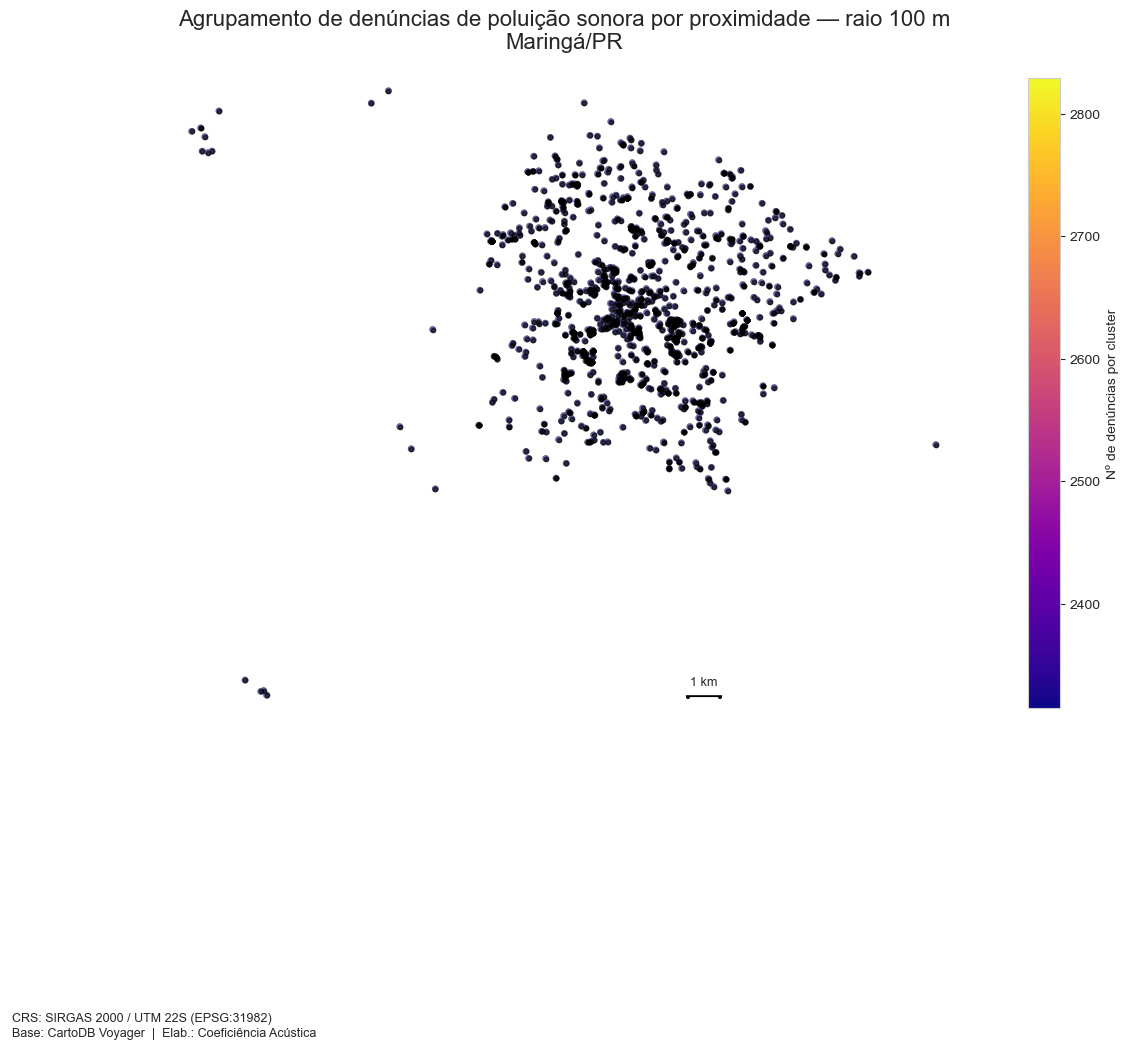

In [19]:
# instalar contextily se estiver ausente (tente instalar via pip; pode não resolver dependências nativas)
%pip install contextily

import geopandas as gpd
# Contextily pode falhar em ambientes com dependências nativas faltando (gdal/rasterio/libnetcdf).
# Importamos em try/except e permitimos continuar sem basemap se necessário.
try:
    import contextily as cx
    cx_available = True
except Exception as e:
    cx = None
    cx_available = False
    print("contextily não disponível ou falhou ao importar. Basemap será ignorado.")
    print("Erro:", e)

# raio em metros para agrupar (ajuste se quiser)
buf_raio = 100

# cria GeoDataFrame a partir de df2 (assume colunas 'longitude' e 'latitude')
pts = df2.dropna(subset=['longitude', 'latitude']).copy()
gdf = gpd.GeoDataFrame(
    pts,
    geometry=gpd.points_from_xy(pts['longitude'], pts['latitude']),
    crs='EPSG:4326'  # WGS84
)

# trabalhar em metros no CRS local (SIRGAS 2000 / UTM 22S)
g = gdf.to_crs(epsg=31982)

# 1) buffer nos pontos e 2) dissolver áreas que se tocam (unir polígonos)
buf = g.geometry.buffer(buf_raio)

# unary_union pode retornar um único polígono ou uma coleção — normaliza para lista
union = buf.unary_union
try:
    polys = list(union)
except TypeError:
    polys = [union]

clusters = gpd.GeoDataFrame(geometry=polys, crs=g.crs).reset_index(drop=True)

# 3) contar pontos por cluster (spatial join)
pts_in = gpd.sjoin(g, clusters, predicate='within', how='left')
counts = pts_in.groupby('index_right').size()
clusters['n'] = counts.reindex(clusters.index, fill_value=0)

# 4) plot
fig, ax = plt.subplots(figsize=(12, 12))
clusters.plot(column='n', cmap='plasma', alpha=0.6,
              edgecolor='black', linewidth=0.3, ax=ax,
              legend=True, legend_kwds={'label': 'Nº de denúncias por cluster', 'shrink': 0.6})

# plotar os pontos por cima
g.plot(ax=ax, color='black', markersize=10, alpha=0.6)

# adicionar basemap (contextily aceitará o CRS dos dados) — só se disponível
if cx_available:
    try:
        cx.add_basemap(ax, crs=clusters.crs.to_string(), source=cx.providers.CartoDB.Voyager)
    except Exception as e:
        print("Falha ao adicionar basemap via contextily. Continuando sem basemap.")
        print("Erro:", e)
else:
    print("Basemap ignorado — contextily não disponível ou falhou no ambiente.")
    print("Se desejar o basemap, resolva as dependências nativas (gdal/rasterio/libnetcdf) ou use um ambiente conda com esses pacotes instalados.")

ax.set_title(
    f'Agrupamento de denúncias de poluição sonora por proximidade — raio {buf_raio} m\nMaringá/PR',
    fontsize=16
)
ax.set_axis_off()

# 6) escala simples
def add_scalebar(ax, length=1000, location=(0.65, 0.05), linewidth=3):
    x0, x1 = ax.get_xlim(); y0, y1 = ax.get_ylim()
    x = x0 + location[0] * (x1 - x0)
    y = y0 + location[1] * (y1 - y0)
    ax.plot([x, x + length], [y, y], color='k', linewidth=linewidth)
    ax.plot([x, x], [y - (y1 - y0) * 0.003, y + (y1 - y0) * 0.003], color='k', linewidth=linewidth)
    ax.plot([x + length, x + length], [y - (y1 - y0) * 0.003, y + (y1 - y0) * 0.003], color='k', linewidth=linewidth)
    label = f'{int(length/1000)} km' if length >= 1000 else f'{length} m'
    ax.text(x + length / 2, y + (y1 - y0) * 0.01, label, ha='center', va='bottom', fontsize=9, backgroundcolor='white')

add_scalebar(ax, length=1000)

# crédito e CRS
ax.annotate('CRS: SIRGAS 2000 / UTM 22S (EPSG:31982)\nBase: CartoDB Voyager  |  Elab.: Coeficiência Acústica',
            xy=(0.01, 0.01), xycoords='figure fraction', fontsize=9,
            ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.8))

plt.tight_layout()
plt.show()